# Exploring Proteomics Reproducibility with NLP

_Austin Keller - University of Washington - 2019-05-15_

I'm curious about what information is contained in the text descriptions of proteomics projects that can help in automatically reproducing work. Projects such as Param-Medic[1](https://www.ncbi.nlm.nih.gov/pubmed/28263070) attempt to automatically determine run parameters for peptide searches using only the raw experiment files. These parameters include experiment type or peptide modifications, which are inferred by searching the data for characteristic patterns. I've been working on a project where we try to extend this to automatically infer the species by searching a subset of the data and reporting the most likely match. However, this doesn't always succeed and even subset searches are time-consuming.

I'd like to find out whether common NLP tools can automatically learn run parameters from the archive descriptions, abstracts, or even full papers. This could supplement tools like Param-Medic in ensuring reproducibility and standardizing proteomics computational workflows. It may also help in automatically categorizing the quality of the research done. Param-Medic failing to find paramameters or incorrectly classifying the data can be used to flag the data as possibly poor quality. I don't think this was an intended feature of Param-Medic but it could be a useful one for pruning poor quality data in large-scale studies. Maybe an exploration with NLP will also uncover unexpected useful heuristics.

There are several archives I could use such as PRIDE, PanoramaPublic, MassIVE, and Chorus. There's also the meta-archive ProteomeXchange. I'm selecting PRIDE for this first investigation. The data is clean and well structured, there's a lot of it (7000+) experiments, and importantly there are long text descriptions that I can access directly through the API.

# Collecting the Raw Data

This page provides an example of the information we can pull directly from PRIDE: https://www.ebi.ac.uk/pride/archive/projects/PXD009005

There are 7000+ such experiments with descriptions and classifications (such as instrument type, experiment type, modifications) that we can try predicting. There are also links to the papers for each experiment, which we _could_ collect and process, but let's hold off on that for now.

Let's get started and pull descriptions and experiment classifications from the PRIDE Archive REST API. It's a simple API and we could write it ourself using `requests` but there's a nice wrapper written by bioservices that appears to be complete.

The URL for the API provides it's own interactive documentation: https://www.ebi.ac.uk/pride/ws/archive/
The relevant code for bioservices, which appears to have all of the functions we want: https://github.com/cokelaer/bioservices/blob/master/src/bioservices/pride.py

In [36]:
import pandas as pd
from bioservices import PRIDE
import sys

In [9]:
pride = PRIDE()

In [17]:
num_projects = pride.get_project_count()
num_projects

7588

In [18]:
pride.get_project_list?

In [24]:
pride.get_project_list(show=10, page=0)[0]

{'accession': 'PXD005994',
 'title': 'Aspergillus fumigatus melanin manipulates the cargo and kinetics of neutrophil-derived extracellular vesicles',
 'projectDescription': 'Neutrophil-derived extracellular vesicles have regained scientif',
 'publicationDate': '2019-05-17',
 'submissionType': 'PARTIAL',
 'numAssays': 0,
 'species': ['Neosartorya fumigata (Aspergillus fumigatus)'],
 'tissues': [],
 'ptmNames': ['iodoacetamide derivatized residue',
  'TMT6plex-126 reporter+balance reagent acylated residue'],
 'instrumentNames': ['Q Exactive'],
 'projectTags': ['Biological', 'Biomedical']}

In [23]:
page_size = 1000
project_list = []

for offset in range(0, num_projects, page_size):
    project_list.extend(pride.get_project_list(show=page_size, page=offset//page_size))
    print(len(project_list))


1000
2000
3000
4000
5000
6000
7000
7588


Great, we now have the full listing of accession numbers, which is what we're after. With these we can pull the experiment page data with full descriptions and classes

In [33]:
len(project_list[0:10])

10

In [41]:
project_full_list = []

for accession in map(lambda x: x['accession'], project_list[0:]):
    project_full_list.append(pride.get_project(accession))
    sys.stdout.write("\r{}/{}".format(len(project_full_list), len(project_list)))

7516/7588

CRITICAL[bioservices:PRIDE]:  HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /pride/ws/archive/project/PRD000066 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Read timed out. (read timeout=30)",))
CRITICAL[bioservices:PRIDE]:  Issue. Maybe your current timeout is 30 is not sufficient. 
Consider increasing it with settings.TIMEOUT attribute


7588/7588

In [51]:
# Uh oh, looks like we might have failed transfers

for i, c in enumerate(project_full_list):
    if c is None:
        print(i)

7516


In [53]:
# Yep, let's add those in manually
project_full_list[7516] = pride.get_project(project_list[7516]['accession'])

CRITICAL[bioservices:PRIDE]:  HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /pride/ws/archive/project/PRD000066 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Read timed out. (read timeout=30)",))
CRITICAL[bioservices:PRIDE]:  Issue. Maybe your current timeout is 30 is not sufficient. 
Consider increasing it with settings.TIMEOUT attribute


In [56]:
print(project_full_list[7516])
print(project_list[7516])

None
{'accession': 'PRD000066', 'title': 'Quantitative Proteomics Analysis of the Secretory Pathway', 'projectDescription': 'Not available', 'publicationDate': '2009-06-16', 'submissionType': 'PRIDE', 'numAssays': 4090, 'species': ['Rattus norvegicus (Rat)'], 'tissues': [], 'ptmNames': [], 'instrumentNames': ['Not Specified'], 'projectTags': []}


In [61]:
# Nevermind, looks like that project is just no good. Let's remove that project from the list and keep going

In [62]:
import copy
pfl_bak = copy.deepcopy(project_full_list)

In [63]:
pfl_trim = project_full_list[:7516] + project_full_list[7517:]
print(len(pfl_trim))

7587


In [67]:
len(pfl_trim)

7587

In [80]:
# Let's save this data so that we don't have to transfer again
import pickle

with open('raw/PRIDE_projects_raw_download.pkl', 'wb') as f:
    pickle.dump(pfl_trim, f)

In [81]:
with open('raw/PRIDE_projects_raw_download.pkl', 'rb') as f:
    pfl_loaded = pickle.load(f)

print(len(pfl_loaded))

7587


In [82]:
# Now let's try to save it in a more structured format by wrangling it into a pandas dataframe

In [71]:
import pprint

pprint.sorted = lambda x, key=None: x
pprint.pprint(pfl_trim[0])

{'accession': 'PXD005994',
 'title': 'Aspergillus fumigatus melanin manipulates the cargo and kinetics of '
          'neutrophil-derived extracellular vesicles',
 'projectDescription': 'Neutrophil-derived extracellular vesicles have '
                       'regained scientific interest as potent ‘wireless’ '
                       'modulators with pleiotropic effects on the immune '
                       'system. A few studies have addressed their role in the '
                       'context of microbial pathogenesis showing their '
                       'bacteriostatic effects against Staphylococcus aureus '
                       'in vitro and their potential as diagnostic markers in '
                       'the onset of bacterimic sepsis in vivo. Here, we '
                       'provided first insights into the vesicle release '
                       'driven by the clinically relevant pathogenic fungus '
                       'Aspergillus fumigatus that causes invasive inf

                           'OpenMS method a max. retention time difference of '
                           '0.33 min, a max. m/z difference of 10 ppm, a '
                           'q-value threshold of 0.01 and a protein level '
                           'false discovery rate of <0.05 was used. The '
                           'abundance values were normalized based on the '
                           'total peptide amount. Only unique peptides were '
                           'considered for quantification. The significance '
                           'threshold for differential protein regulation was '
                           'set to factor ≥2.0 (up- or down-regulation).',
 'otherOmicsLink': None,
 'numProteins': 0,
 'numPeptides': 0,
 'numSpectra': 0,
 'numUniquePeptides': 0,
 'numIdentifiedSpectra': 0,
 'references': []}


In [40]:
# The following code fails to run because there's missing data at index 2972. Let's trim that piece out too
#pd.DataFrame(pfl_trim)

In [105]:
pd.DataFrame([pfl_trim[2972]])

,0
0,401


In [110]:
print(len(pfl_trim))
print(len(pfl_trim[:2972] + pfl_trim[2973:]))
pfl_trim_2 = pfl_trim[:2972] + pfl_trim[2973:]

7587
7586


In [113]:
df = pd.DataFrame(pfl_trim_2)

In [114]:
df.head()

,accession,dataProcessingProtocol,doi,experimentTypes,instrumentNames,keywords,labHeads,numAssays,numIdentifiedSpectra,numPeptides,...,quantificationMethods,reanalysis,references,sampleProcessingProtocol,species,submissionDate,submissionType,submitter,tissues,title
0,PXD005994,Protein database search and reporter ion quant...,None,[Shotgun proteomics],[Q Exactive],"neutrophils, antifungal extracellular vesicles...","[{'title': 'Dr', 'firstName': 'Axel A.', 'last...",0,0,0,...,[TMT],None,[],Purified ectosomes from 20 different donors we...,[Neosartorya fumigata (Aspergillus fumigatus)],2017-03-01,PARTIAL,"{'title': 'Dr', 'firstName': 'Thomas', 'lastNa...",[],Aspergillus fumigatus melanin manipulates the ...
1,PXD011176,"Protein sample were loaded onto SDS-PAGE gel, ...",None,[Shotgun proteomics],[Q Exactive],"Pseudostuga, embryonal mass, non-embryogenic c...","[{'title': 'Dr', 'firstName': 'Stephane', 'las...",0,0,0,...,[Label free],None,"[{'desc': 'Gautier F, Label P, Eliášová K, Lep...",Soluble proteins extracts were prepared from f...,[Pseudotsuga menziesii],2018-09-24,PARTIAL,"{'title': 'Dr', 'firstName': 'Claverol', 'last...",[embryo],"Cytological, biochemical and molecular events ..."
2,PXD013341,Data processing of IDA-data The ten data file...,None,[SWATH MS],[TripleTOF 5600],"Non-canonical amino acid labelling, tauopathy,...","[{'title': 'Dr', 'firstName': 'Professor Jürge...",0,0,0,...,[SWATH MS],None,[],One brain hemisphere from each mouse was snap-...,[Mus musculus (Mouse)],2019-05-16,PARTIAL,"{'title': 'Mr', 'firstName': 'Harrison', 'last...",[brain],Decreased synthesis of ribosomal proteins in t...
3,PXD012043,Raw data were converted to mzXML and mapped vi...,None,[Shotgun proteomics],[Orbitrap Fusion Lumos],"drug adaptation, tyrosine kinase inhibitor, hu...","[{'title': 'Dr', 'firstName': 'Peter K.', 'las...",0,0,0,...,[TMT],None,"[{'desc': 'Wang H, Sheehan RP, Palmer AC, Ever...","hiPSC-CMs were cultured in 60 mm plates, then ...",[Homo sapiens (Human)],2018-12-13,PARTIAL,"{'title': 'Mr', 'firstName': 'Matthew', 'lastN...",[heart],Total protein profiles of human induced plurip...
4,PXD013183,The MaxQuant software package version 1.5.1.2 ...,None,[Affinity purification coupled with mass spect...,[Q Exactive],Proximity-dependent biotinylation; TurboID; ye...,"[{'title': 'Dr', 'firstName': 'Francois', 'las...",0,0,0,...,[],None,"[{'desc': 'Larochelle M, Bergeron D, Arcand B,...",Trypsin digested samples were analyzed by liqu...,[Schizosaccharomyces pombe 927],2019-03-21,PARTIAL,"{'title': 'Mr', 'firstName': 'Danny', 'lastNam...",[],Proximity-dependent biotinylation by TurboID t...


In [115]:
df.to_json("raw/PRIDE_projects.json")

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_json("raw/PRIDE_projects.json")

In [3]:
df.head()

,accession,dataProcessingProtocol,doi,experimentTypes,instrumentNames,keywords,labHeads,numAssays,numIdentifiedSpectra,numPeptides,numProteins,numSpectra,numUniquePeptides,otherOmicsLink,projectDescription,projectTags,ptmNames,publicationDate,quantificationMethods,reanalysis,references,sampleProcessingProtocol,species,submissionDate,submissionType,submitter,tissues,title
0,PXD005994,Protein database search and reporter ion quant...,None,[Shotgun proteomics],[Q Exactive],"neutrophils, antifungal extracellular vesicles...","[{'title': 'Dr', 'firstName': 'Axel A.', 'last...",0,0,0,0,0,0,None,Neutrophil-derived extracellular vesicles have...,"[Biological, Biomedical]","[iodoacetamide derivatized residue, TMT6plex-1...",2019-05-17,[TMT],None,[],Purified ectosomes from 20 different donors we...,[Neosartorya fumigata (Aspergillus fumigatus)],2017-03-01,PARTIAL,"{'title': 'Dr', 'firstName': 'Thomas', 'lastNa...",[],Aspergillus fumigatus melanin manipulates the ...
1,PXD011176,"Protein sample were loaded onto SDS-PAGE gel, ...",None,[Shotgun proteomics],[Q Exactive],"Pseudostuga, embryonal mass, non-embryogenic c...","[{'title': 'Dr', 'firstName': 'Stephane', 'las...",0,0,0,0,0,0,None,Objectives: to characterize and to better unde...,[],"[iodoacetamide derivatized residue, monohydrox...",2019-05-17,[Label free],None,"[{'desc': 'Gautier F, Label P, Eliášová K, Lep...",Soluble proteins extracts were prepared from f...,[Pseudotsuga menziesii],2018-09-24,PARTIAL,"{'title': 'Dr', 'firstName': 'Claverol', 'last...",[embryo],"Cytological, biochemical and molecular events ..."
10,PXD011695,The resulting tandem mass spectra were searche...,None,[Shotgun proteomics],"[LTQ Orbitrap Elite, Q Exactive]","Shotgun Proteomics, HCD, ETD, EThcD, ETcaD, AI...","[{'title': 'Dr', 'firstName': 'Joshua J.', 'la...",0,0,0,0,0,0,None,"Abstract Here we present IPSA, an innovative w...",[],"[iodoacetamide derivatized residue, monohydrox...",2019-05-15,[],None,"[{'desc': 'Brademan DR, Riley NM, Kwiecien NW,...",Cell pellets of Saccharomyces cerevisiae (stra...,"[Mus musculus (Mouse), Saccharomyces cerevisia...",2018-11-14,PARTIAL,"{'title': 'Mr', 'firstName': 'Dain', 'lastName...",[brain],Interactive Peptide Spectral Annotator Experim...
100,PXD013307,Thermo RAW files were processed with MaxQuant ...,None,[Shotgun proteomics],"[LTQ Orbitrap, Orbitrap Fusion Lumos]","Metabolomics, proteomics, biofilm modeling","[{'title': 'Dr', 'firstName': 'Daniel', 'lastN...",0,0,0,0,0,0,None,Biofilms are structured communities of tigh...,[],"[iodoacetamide derivatized residue, monohydrox...",2019-04-30,[Peptide counting],None,[],The lysis method used on B. subtilis pellet wa...,[Bacillus subtilis subsp. subtilis str. NCIB 3...,2019-03-29,PARTIAL,"{'title': 'Miss', 'firstName': 'Edna Angelica'...",[],Metabolic remodeling during biofilm developmen...
1000,PXD009203,The LC-MS/MS analysis was performed on an LTQ ...,10.6019/PXD009203,[Shotgun proteomics],[LTQ Orbitrap Elite],"Human, bladder, tissue, LC-MS/MS","[{'title': 'Dr', 'firstName': 'Barbara', 'last...",20,0,206952,44807,591744,125446,None,A quantitative label-free proteome analysis of...,[Biomedical],"[Carbamidomethyl, Oxidation]",2018-12-03,[MS1 intensity based label-free quantification...,None,[],Vials containing lasermicrodissected tissue we...,[Homo sapiens (Human)],2018-03-14,COMPLETE,"{'title': 'Dr', 'firstName': 'Thilo', 'lastNam...",[urinary bladder],Integrated FTIR imaging and proteomics for ide...


## references

In [4]:
sorted(df.references.apply(lambda x: len(x)).unique())

[0, 1, 2, 3, 4, 5, 9, 16]

In [5]:
df[df.references.apply(lambda x: len(x) > 0)].shape

(6637, 28)

Most of the entries (6637) have a reference attached on which we could do more extensive NLP

## submissionType

In [6]:
df.submissionType.unique()

array(['PARTIAL', 'COMPLETE', 'PRIDE'], dtype=object)

In [7]:
df[df.references.apply(lambda x: len(x) > 0) & ((df.submissionType == 'COMPLETE') | (df.submissionType == 'PRIDE'))].shape

(1751, 28)

Many datasets are not 'COMPLETE', though I'm not sure how that's defined. As long as the submissions have descriptions or references and nice categorical labels, we can perform the classification we set out to do.

In [8]:
df.references.apply(lambda x: len(x) > 0).shape

(7586,)

## experimentTypes

Num projects unlabeled: 0
Num unique: 16
array(['Shotgun proteomics',
       'Affinity purification coupled with mass spectrometry proteomics',
       'Top-down proteomics', 'Gel-based experiment', 'HDMSE', 'SWATH MS',
       'SRM/MRM', 'Bottom-up proteomics',
       'Chemical cross-linking coupled with mass spectrometry proteomics',
       'Mass spectrometry imaging', 'All-ion fragmentation', 'MSE',
       'PAcIFIC', 'Gel-free quantification method',
       'Two Dimensional Polyacrylamide Gel Electrophoresis',
       'iTRAQ reagent'], dtype=object)


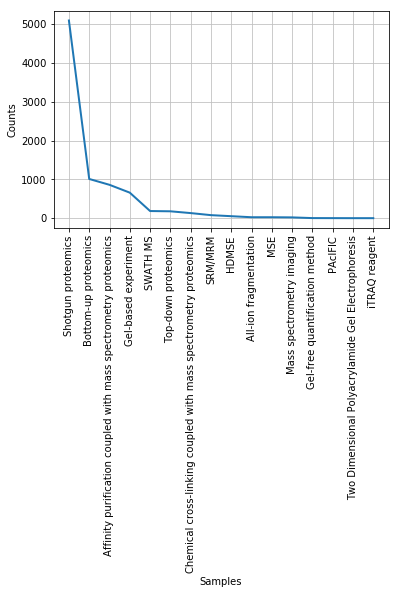

In [9]:
print("Num projects unlabeled: " + str(df[~df.experimentTypes.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.experimentTypes for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.experimentTypes for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.experimentTypes for item in sublist])

freq.plot(20, cumulative=False)

## instrumentNames

Num projects unlabeled: 0
Num unique: 129
array(['Q Exactive', 'LTQ Orbitrap Elite', 'LTQ Orbitrap',
       'Orbitrap Fusion Lumos', 'LTQ Orbitrap Velos', 'Q Exactive HF',
       'Orbitrap Fusion', 'LTQ', 'TripleTOF 5600', 'LTQ Orbitrap XL',
       'Synapt G2 MS', 'Synapt MS', 'Q-Tof Premier', 'ultraflex TOF/TOF',
       '6520 Quadrupole Time-of-Flight LC/MS', 'ultraflex', 'LTQ FT',
       'TripleTOF 5600+', 'liquid chromatography separation',
       'Orbitrap Fusion ETD', '6410 Triple Quadrupole LC/MS',
       'Q Exactive Plus', 'maXis', 'TSQ Vantage', 'QSTAR',
       'Q Exactive HF-X', 'Bruker Daltonics instrument model',
       'Q-Tof ultima', 'Bruker Daltonics micrOTOF series',
       'Thermo Scientific', 'autoflex', 'Agilent instrument model',
       '6220 Time-of-Flight LC/MS', 'AB SCIEX instrument model',
       '4800 Proteomics Analyzer', 'Bruker Daltonics maXis series',
       'apex ultra', 'Synapt G2-S HDMS', 'Synapt HDMS', 'maXis 4G',
       'LTQ Velos', 'LTQ Orbitap Discove

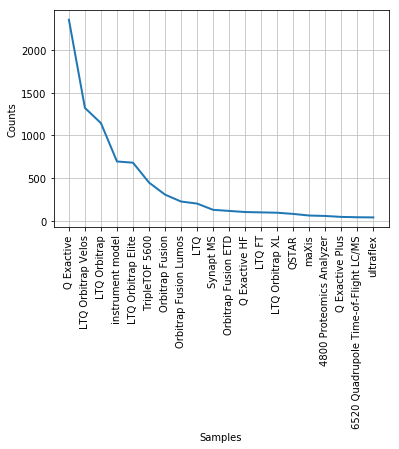

In [10]:
print("Num projects unlabeled: " + str(df[~df.instrumentNames.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.instrumentNames for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.instrumentNames for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.instrumentNames for item in sublist])

freq.plot(20, cumulative=False)

## keywords

Num projects unlabeled: 0
Num unique: 14214
array(['neutrophils', 'antifungal extracellular vesicles',
       'Aspergillus fumigatus', ...,
       'human umbilical vein endothelial cells (HUVECs)',
       'primary human osteoblasts (hOBs)',
       'stable isotope labeling by amino acids in cell culture (SILAC)'],
      dtype=object)


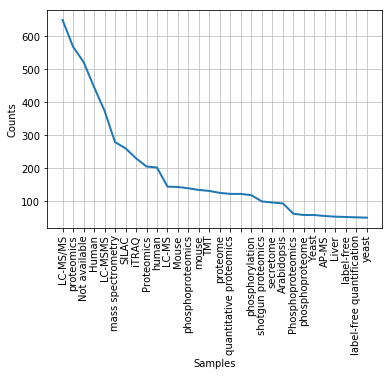

In [11]:
#df_keywords = df.keywords.apply(lambda x: list(map(lambda x: x.strip(), x.split(','))))
df_keywords = df.keywords.apply(lambda x: list(map(lambda x: x.strip(), x.replace(';', ',').replace(' / ', ',').split(','))))
print("Num projects unlabeled: " + str(df[df_keywords.apply(lambda x: set(x) == set(['']))].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df_keywords for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df_keywords for item in sublist]))
freq = nltk.FreqDist([item for sublist in df_keywords for item in sublist])

freq.plot(30, cumulative=False)

## numAssays

In [12]:
df[df.numAssays != 0].shape

(2052, 28)

[]

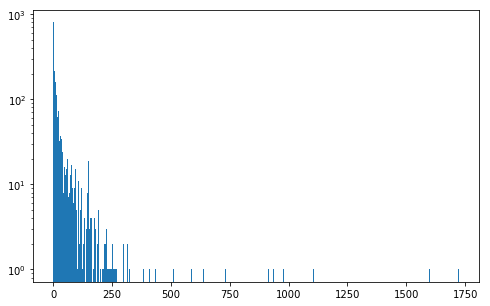

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df[df.numAssays != 0].numAssays, bins='auto', log=True)
plt.plot()

## numSpectra

In [14]:
df[df.numSpectra != 0].shape

(1977, 28)

[]

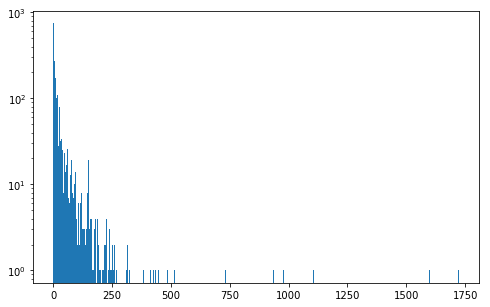

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df[df.numSpectra != 0].numAssays, bins='auto', log=True)
plt.plot()

## numPeptides

In [16]:
df[df.numPeptides != 0].shape

(1933, 28)

[]

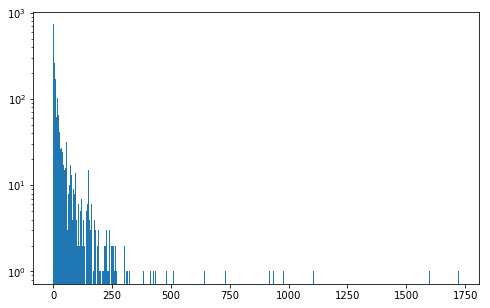

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df[df.numPeptides != 0].numAssays, bins='auto', log=True)
plt.plot()

In [18]:
df[~df.otherOmicsLink.isna()].head()

,accession,dataProcessingProtocol,doi,experimentTypes,instrumentNames,keywords,labHeads,numAssays,numIdentifiedSpectra,numPeptides,numProteins,numSpectra,numUniquePeptides,otherOmicsLink,projectDescription,projectTags,ptmNames,publicationDate,quantificationMethods,reanalysis,references,sampleProcessingProtocol,species,submissionDate,submissionType,submitter,tissues,title
1021,PXD007599,All spectra (.raw files) generated from MS wer...,None,[Shotgun proteomics],[LTQ Orbitrap],"carnivorous, enzymes, LC-MS, Nepenthes, orbitr...","[{'title': 'Dr', 'firstName': 'HOE-HAN', 'last...",0,0,0,0,0,0,http://www.ncbi.nlm.nih.gov/sra/SRX2692198. ht...,"Pitcher fluids from 3 species of Nepenthes, na...",[Biological],[iodoacetamide derivatized residue],2018-11-29,[],None,[],Collected pitcher fluids were filtered through...,"[Nepenthes ampullaria, Nepenthes rafflesiana, ...",2018-11-28,PARTIAL,"{'title': 'Dr', 'firstName': 'Hoe-Han', 'lastN...",[pitcher secretion],Pitcher fluid protein profiling from Nepenthes...
1031,PXD011187,All raw data files from Xcalibur software were...,None,[Shotgun proteomics],"[LTQ Orbitrap Elite, Q Exactive]","Phosphoproteome,ALK inhibition,neuroblastoma,o...","[{'title': 'Dr', 'firstName': 'Bengt', 'lastNa...",0,0,0,0,0,0,E-MTAB-6654,Neuroblastoma is a neural crest-derived embryo...,[Biomedical],"[iodoacetamide derivatized residue, phosphoryl...",2018-11-27,[Normalized Spectral Abundance Factor - NSAF],None,"[{'desc': 'Van den Eynden J, Umapathy G, Ashou...",Tyrosine/serine/threonine profiling was perfor...,[Homo sapiens (Human)],2018-09-25,PARTIAL,"{'title': 'Dr', 'firstName': 'Vicky', 'lastNam...","[brain, bone marrow]",Phosphoproteome and gene expression profiling ...
1059,PXD009332,Spectra data were acquired in MS and MS/MS mod...,10.6019/PXD009332,[Gel-based experiment],[ultraflex TOF/TOF],"Histomonas meleagridis, protozoa, comparative ...","[{'title': 'Dr', 'firstName': 'Dr. Ivana', 'la...",42,0,198,56,199,171,The current dataset can be linked to the publi...,The current work aimed to detect and identify ...,[Biomedical],"[Carbamidomethyl, Oxidation, Gln->pyro-Glu, De...",2018-11-22,[],None,"[{'desc': 'Monoyios A, Hummel K, Nöbauer K, Pa...",Significantly differentially abundant protein ...,[Histomonas meleagridis],2018-03-26,COMPLETE,"{'title': 'Dr', 'firstName': 'Ivana', 'lastNam...",[cell culture],An alliance of gel-based and gel-free proteomi...
108,PXD012225,Peptide spectral matching was performed with M...,10.6019/PXD012225,[Chemical cross-linking coupled with mass spec...,"[Orbitrap Fusion Lumos, Q Exactive]","Fibrin, Clot, ECM, insoluble protein, matrix, ...","[{'title': 'Dr', 'firstName': 'Kirk C', 'lastN...",3,0,732569,22837,682462,115031,https://www.yeastrc.org/proxl_public/viewProje...,Here we present characterization of fibrin clo...,[Technical],"[Carbamidomethyl, Cys->Dha, Oxidation, Trioxid...",2019-04-26,[],None,[],"For development, human blood from a healthy do...",[Homo sapiens (Human)],2019-01-03,COMPLETE,"{'title': 'Dr', 'firstName': 'Kirk ', 'lastNam...","[blood plasma, blood]",Molecular Mapping of FXIIIa Crosslinks
1095,PXD007154,Raw data of all experiments except histone PTM...,None,[Affinity purification coupled with mass spect...,"[Synapt MS, Orbitrap Fusion, Q Exactive]","Chromatin profiling, mouse embryonic stem cell...","[{'title': 'Dr', 'firstName': 'Hendrik', 'last...",0,0,0,0,0,0,GSE101675,The ground state of pluripotency is defined as...,[Biological],"[formylated residue, dimethylated residue, N6-...",2018-11-21,[],None,[],"For whole cell proteomes, cells were lysed in ...",[Mus musculus (Mouse)],2017-08-09,PARTIAL,"{'title': 'Mr', 'firstName': 'Guido', 'lastNam...",[],Integrative proteomics reveals a protective ro...


In [19]:
df[~df.otherOmicsLink.isna()].shape

(234, 28)

## projectDescription

In [20]:
df[~df.projectDescription.isna()].shape

(7580, 28)

Let's skip the NLP processing for now and finish reviewing our numerical and categorical data

## projectTags

Num projects unlabeled: 1257
Num unique: 34
array(['Biological', 'Biomedical', 'Technical',
       'Glycoproteomics (B/D-HPP)', 'Metaproteomics',
       'Biology/Disease-Driven Human Proteome Project (B/D-HPP)',
       'Human Proteome Project',
       'Human Brain Proteome Project (HUPO_HBPP) (B/D-HPP)',
       'Liver (B/D-HPP)',
       'Chromosome-centric Human Proteome Project (C-HPP)',
       'Cancer (B/D-HPP)', 'CPTAC Consortium',
       'Protein Misfolding and Aggregation (B/D-HPP)',
       'China Human Proteome Project (CNHPP)',
       'Epigenetic Chromatin (B/D-HPP)',
       'Skeletal Muscle Proteome (B/D-HPP)',
       'Malaria Host-Pathogen Interaction Center (MaHPIC)',
       'PRIME-XS Project', 'Cardiovascular (B/D-HPP)',
       'Diabetes (B/D-HPP)', 'ProteomeTools', 'Reference',
       'EyeOME (B/D-HPP)', 'Food and Nutrition (B/D-HPP)',
       'Kidney Urine (B/D-HPP)',
       'Bioinformatics Infrastructure for Life Sciences (BILS) network (Sweden)',
       'Extreme Condition

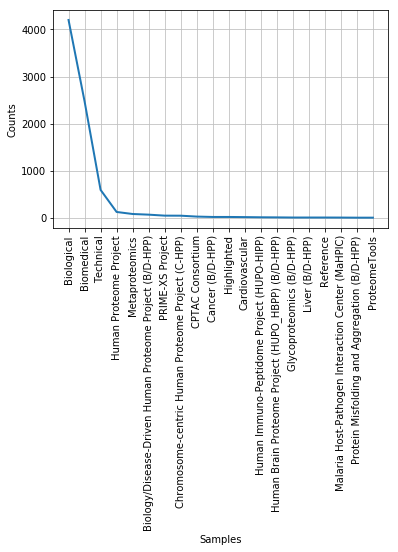

In [57]:
print("Num projects unlabeled: " + str(df[~df.projectTags.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.projectTags for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.projectTags for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.projectTags for item in sublist])

freq.plot(20, cumulative=False)

## ptmNames

Num unique: 1195
array(['iodoacetamide derivatized residue',
       'TMT6plex-126 reporter+balance reagent acylated residue',
       'monohydroxylated residue', ..., 'Iodoacetamide derivative',
       'S-cyano-L-cysteine', 'Dehydro'], dtype=object)


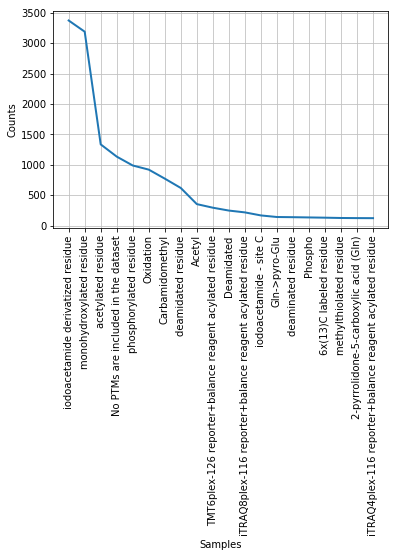

In [22]:
print("Num unique: " + str(len(pd.unique([item for sublist in df.ptmNames for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.ptmNames for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.ptmNames for item in sublist])

freq.plot(20, cumulative=False)

## publicationDate

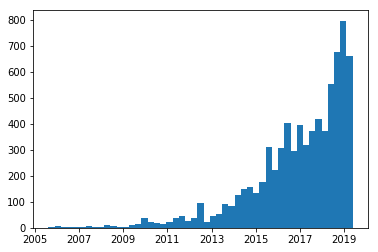

We add a plot binned to the month so that we can have an idea of the monthly publication rate:


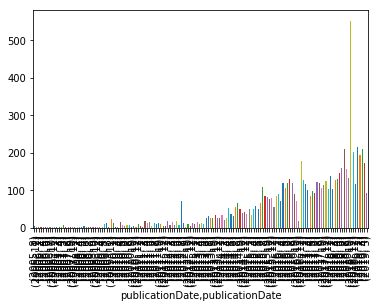

In [33]:
df.publicationDate = df.publicationDate.astype("datetime64")
plt.hist(df.publicationDate, bins='auto')
plt.show()

print("We add a plot binned to the month so that we can have an idea of the monthly publication rate:")
df.publicationDate.groupby([df.publicationDate.dt.year, df.publicationDate.dt.month]).count().plot(kind="bar")
plt.show()

## quantificationMethods

Num projects unlabeled: 3966
Num unique: 63
['TMT' 'Label free' 'Peptide counting'
 'MS1 intensity based label-free quantification method' 'Spectrum counting'
 'SILAC' 'Variable modification' 'Peptide mass tolerance setting'
 'Identified by peptide fragmentation' 'Peptide selection'
 'Peptide search engine output parameter' 'Data-independent acquisition'
 'Normalized Spectral Abundance Factor - NSAF' 'TIC'
 'Protein Abundance Index - PAI' 'Spectrum count/molecular weight'
 'Parallel Reaction Monitoring (PRM)' 'iTRAQ'
 'APEX - Absolute Protein Expression' 'emPAI' 'AQUA' 'SWATH MS'
 'Isotope labeling' 'Spectral Abundance Factor - SAF' 'precursor ion'
 'MS1 based isotope labeling' 'Gel spot volume'
 'Gel-based quantification method' 'Heavy stable isotope label' 'ICAT'
 'Stable isotope ratio' 'Gel-free quantification method'
 'Mass spectrometry' 'All peptides matched' 'Absolute quantification unit'
 'LC-MS label-free quantitation analysis' 'Mascot score' 'MSE' '18O'
 'HDMSE' 'Relative quan

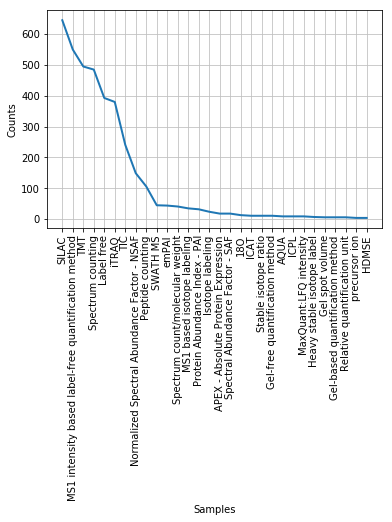

In [56]:
print("Num projects unlabeled: " + str(df[~df.quantificationMethods.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.quantificationMethods for item in sublist]))))
print(pd.unique([item for sublist in df.quantificationMethods for item in sublist])[:50])
freq = nltk.FreqDist([item for sublist in df.quantificationMethods for item in sublist])

freq.plot(30, cumulative=False)

## species

Num projects unlabeled: 15
Num unique: 1527
['Neosartorya fumigata (Aspergillus fumigatus)' 'Pseudotsuga menziesii'
 'Mus musculus (Mouse)' "Saccharomyces cerevisiae (Baker's yeast)"
 'Bacillus subtilis subsp. subtilis str. NCIB 3610' 'Homo sapiens (Human)'
 'Microbacterium sp.' 'Leishmania donovani' 'Camellia sinensis'
 'uncultured soil bacterium S0137' 'Fasciola hepatica (Liver fluke)'
 'Staphylococcus haemolyticus' 'Cyanea capillata' 'Nemopilema nomurai'
 'Drosophila melanogaster (Fruit fly)' 'Ctenopharyngodon idella'
 'Nepenthes ampullaria' 'Nepenthes rafflesiana' 'Nepenthes x hookeriana'
 'Rattus norvegicus (Rat)']


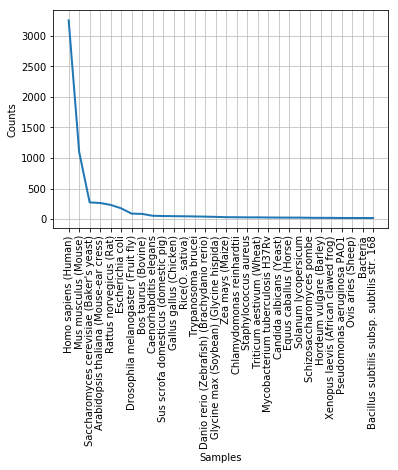

Num species == 1: 6976
Num species > 1: 595


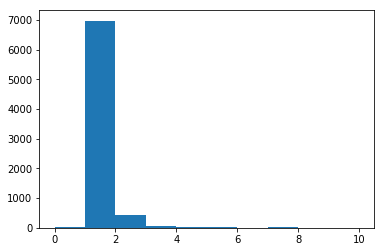

In [91]:
print("Num projects unlabeled: " + str(df[~df.species.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.species for item in sublist]))))
print(pd.unique([item for sublist in df.species for item in sublist])[:20])
freq = nltk.FreqDist([item for sublist in df.species for item in sublist])

freq.plot(30, cumulative=False)
plt.hist(df.species.apply(lambda x: len(x)), bins=list(range(0,11)), cumulative=False)
print("Num species == 1: {}".format(df[df.species.apply(lambda x: len(x) == 1)].shape[0]))
print("Num species > 1: {}".format(df[df.species.apply(lambda x: len(x) > 1)].shape[0]))

## tissues

Num projects unlabeled: 2770
Num unique: 640
['embryo' 'brain' 'urinary bladder' 'cell culture' 'JURKAT cell'
 'blood plasma' 'leaf' 'cerebrospinal fluid' 'nematocyst' 'trophoblast'
 'oocyte' 'Egg' 'tooth enamel' 'urine' 'pitcher secretion' 'lung'
 'bone marrow' 'mycelium' 'spleen' 'lymph node' 'blood serum' 'kidney'
 'skin' 'dental plaque' 'whole plant' 'whole body' 'gastric epithelium'
 'blood platelet' 'blood' 'erythrocyte' 'HeLa cell' 'cell lysate' 'liver'
 'heart' 'retinal pigment epithelium cell' 'colon' 'midgut'
 'haematopoietic stem cells' 'thymus' 'small intestine' 'prostate gland'
 'gut' 'thyroid gland' 'stomach' 'longissimus' 'testis' 'lymph' 'uterus'
 'retina' 'pancreas']


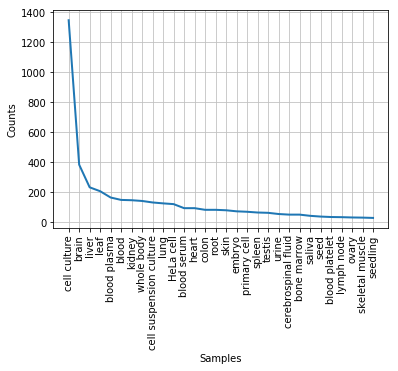

In [54]:
print("Num projects unlabeled: " + str(df[~df.tissues.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.tissues for item in sublist]))))
print(pd.unique([item for sublist in df.tissues for item in sublist])[:50])
freq = nltk.FreqDist([item for sublist in df.tissues for item in sublist])

freq.plot(30, cumulative=False)

## What can we try?

Understanding which species an experiment contains is something that we're trying to do using Param-Medic and short runs of the Tide peptide search tool. Basically, this takes a raw experiment file and tries to infer which species that experiment contains by trying to query it with the FASTA database of each species and seeing which performs the best. Tide produces a series of peptide detections, and we expect that searching with the correct species type will produce the most detections. However, this can't handle experiments with mixtures of species. Another issue is that similar species like mouse and rat can be confused. And each tide search is expensive. Maybe an NLP classification could help distinguish between single and multi-species experiments. Then we could flag the complex experiments for manual insepction. If that works well then we could get fancy and try performing a multi-target classification to fully automate species selection.

# Modeling

In [296]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, feature_selection, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from nltk.corpus import stopwords
import time

stop_words = stopwords.words('english')

Let's try using the descriptions to do a simple binary classification of mixture vs non-mixture.

In [2]:
df = pd.read_json("raw/PRIDE_projects.json")

In [3]:
# Trim out unlabeled data
print("Trimming out {} rows without species labels".format(df[df.species.apply(lambda x: len(x) == 0)].shape[0]))
df = df[df.species.apply(lambda x: len(x) > 0)]

Trimming out 15 rows without species labels


In [4]:
df['multiSpecies'] = df.species.apply(lambda x: len(x) > 1)

I'll combine the descriptive texts into one by concatenating them

In [5]:
df["text"] = df.apply(lambda row: '{} {} {}'.format(row['projectDescription'], row['sampleProcessingProtocol'], row['dataProcessingProtocol']), axis=1)

In [6]:
train = df[["text", "multiSpecies"]]
train.head()

,text,multiSpecies
0,Neutrophil-derived extracellular vesicles have...,False
1,Objectives: to characterize and to better unde...,False
10,"Abstract Here we present IPSA, an innovative w...",True
100,Biofilms are structured communities of tigh...,False
1000,A quantitative label-free proteome analysis of...,False


In [30]:
lbl_enc = preprocessing.LabelEncoder()
#lbl_enc = preprocessing.LabelBinarizer()
y = lbl_enc.fit_transform(train.multiSpecies.values)

In [31]:
xtrain_tmp, xtest, ytrain_tmp, ytest = train_test_split(train.text.values,
                                                y, 
                                                stratify=y,
                                                random_state=1, 
                                                test_size=0.1,
                                                shuffle=True)

xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_tmp,
                                                  ytrain_tmp, 
                                                  stratify=ytrain_tmp,
                                                  random_state=3, 
                                                  test_size=0.1,
                                                  shuffle=True)

In [32]:
print(xtrain.shape)
print(xvalid.shape)
print(xtest.shape)

(6131,)
(682,)
(758,)


In [38]:
print('ytrain class distribution')
print(pd.value_counts(ytrain, normalize=True))
print('yvalid class distribution')
print(pd.value_counts(yvalid, normalize=True))
print('ytest class distribution')
print(pd.value_counts(ytest, normalize=True))

ytrain class distribution
0    0.921546
1    0.078454
dtype: float64
yvalid class distribution
0    0.920821
1    0.079179
dtype: float64
ytest class distribution
0    0.920844
1    0.079156
dtype: float64


In [75]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [76]:
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

Our first model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.

In [62]:
tic = time.time()

tfv = TfidfVectorizer(min_df=3, max_features=None,
                      strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                      stop_words='english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

Runtime: 27.252 seconds


In [310]:
feature_selection.f_classif(xtrain_tfv, ytrain)[0]
# Create an SelectKBest object to select features with two best ANOVA F-Values
fvalue_selector = feature_selection.SelectKBest(feature_selection.f_classif, k=10)

# Apply the SelectKBest object to the features and target
xtrain_tfv_kbest = fvalue_selector.fit_transform(xtrain_tfv, ytrain)
#print(xtrain_tfv)
print(xtrain.shape)
print(xtrain_tfv.shape)
print(xtrain_tfv_kbest.shape)
#print(xtrain)

(6131,)
(6131, 274185)
(6131, 10)


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [71]:
tic = time.time()

# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logloss: 0.263 
Runtime: 1.262 seconds


Instead of using TF-IDF, we can also use word counts as features. This can be done using CountVectorizer from scikit-learn.

In [60]:
tic = time.time()

ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),
                      stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

Runtime: 23.989 seconds


In [61]:
tic = time.time()

# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logloss: 0.442 
Runtime: 17.962 seconds


Next, let's see what happens when we use naive bayes on these two datasets:

In [70]:
tic = time.time()

# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.997 
Runtime: 0.083 seconds


In [63]:
tic = time.time()

# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 2.800 
Runtime: 0.196 seconds


Naive bayes does not do well. Now let's try training an SVM.

In [64]:
tic = time.time()

# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

Runtime: 18.878 seconds


In [72]:
tic = time.time()

# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.277 
Runtime: 16.380 seconds


The SVM does well but not as well as the Logistic Regression. Next, onto XGBoost:

In [133]:
tic = time.time()

# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(silent=False,
                        learning_rate=0.1,
                        n_estimators=100,
                        max_depth=3,
                        subsample=1.0,
                        colsample_bytree=1.0,
                        gamma=1.0,
                        nthread=16)

clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.247 
Runtime: 9.553 seconds


In [134]:
tic = time.time()

# Fitting a simple xgboost on count vectorizer
clf = xgb.XGBClassifier(silent=False,
                        learning_rate=0.1,
                        n_estimators=100,
                        max_depth=3,
                        subsample=1.0,
                        colsample_bytree=1.0,
                        gamma=1.0,
                        nthread=16)

clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_ctv.tocsc())

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.243 
Runtime: 39.106 seconds


In [146]:
tic = time.time()

# Fitting a simple xgboost on count vectorizer
clf = xgb.XGBClassifier(silent=False,
                        learning_rate=0.1,
                        n_estimators=100,
                        max_depth=3,
                        subsample=1.0,
                        colsample_bytree=1.0,
                        gamma=1.0,
                        nthread=16)

clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.264 
Runtime: 0.463 seconds


In [213]:
tic = time.time()

# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=3,
                        n_estimators=100,
                        colsample_bytree=1.0, 
                        subsample=1.0,
                        nthread=16,
                        learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.266 
Runtime: 0.473 seconds


Optimize the XGBoost model for tf-idf

In [208]:
tic = time.time()

# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(silent=False,
                        learning_rate=0.1,
                        n_estimators=100,
                        max_depth=3,
                        subsample=1.0,
                        colsample_bytree=1.0,
                        gamma=1,
                        nthread=16)

clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.247 
Runtime: 9.347 seconds


Optimize the XGBoost model for SVD

In [198]:
tic = time.time()

clf = xgb.XGBClassifier(silent=False,
                        learning_rate=0.1,
                        n_estimators=100,
                        max_depth=3,
                        subsample=0.8,
                        colsample_bytree=1.0,
                        gamma=5,
                        nthread=16)

clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

toc = time.time()
print("Runtime: {:.3f} seconds".format(toc - tic))

logloss: 0.258 
Runtime: 0.446 seconds


Now we'll run a randomized search over our remaining parameters

In [314]:
param_dist = {
    "learning_rate": np.power(10.0, np.random.uniform(-3, 3, 100)),
    "subsample": scipy.stats.uniform(loc=0.8, scale=0.2),
    "colsample_bytree": scipy.stats.uniform(loc=0.8, scale=0.2),
    "gamma": scipy.stats.expon(scale=5),
}

clf = xgb.XGBClassifier(silent=False,
                        learning_rate=0.01,
                        n_estimators=100,
                        max_depth=3,
                        subsample=0.8,
                        colsample_bytree=1.0,
                        gamma=1.0,
                        nthread=16)

model = RandomizedSearchCV(estimator=clf,
                           param_distributions=param_dist,
                           scoring=make_scorer(metrics.log_loss, greater_is_better=False, needs_threshold=True),
                           n_iter=15, cv=3, iid=False)

model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 

print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_dist.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.6/site-packages/sklearn/

Best score: -0.252
Best parameters set:
	colsample_bytree: 0.81719869180932425
	gamma: 0.99484421842366211
	learning_rate: 0.095329585289678137
	subsample: 0.94542153193268985


### Model evaluation

The logistic loss provides a reasonable score to optimize on for a first pass, but we need to look at other metrics and think about what properties are important for us in the practical application of our model. In our proposed use case, we want to split our processing pipeline between datasets that can be safely evaluated using a single FASTA database, and those that need closer inspection. This means that we want a low false negative rate so that multi-species data isn't passed to the single-species pipeline. However, our training data is heavily skewed toward single-species examples, meaning that our model will likely be biased toward reporting negatives (i.e. single species classifications) and will thus be biased towards a high false negative rate. For this reason we'll want to look at precision and recall scores in order to tune our discriminator threshold towards a more acceptable false negative rate.

In [315]:
predictions = model.predict_proba(xvalid_tfv)[:, 1]
print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

# Tune threshold to get better recall
bin_predictions = adjusted_classes(predictions, t=0.35)
print("recall: %0.3f " % metrics.recall_score(yvalid, bin_predictions))
print("precision: %0.3f " % metrics.precision_score(yvalid, bin_predictions))

logloss: 0.249 
recall: 0.111 
precision: 0.667 


In [316]:
p, r, thresholds = metrics.precision_recall_curve(yvalid, predictions)

In [317]:
from inspect import signature

def precision_recall_threshold(p, r, thresholds, y_scores, y_test, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, alpha=0.2, color='b', **step_kwargs)
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg       628         0
pos        50         4


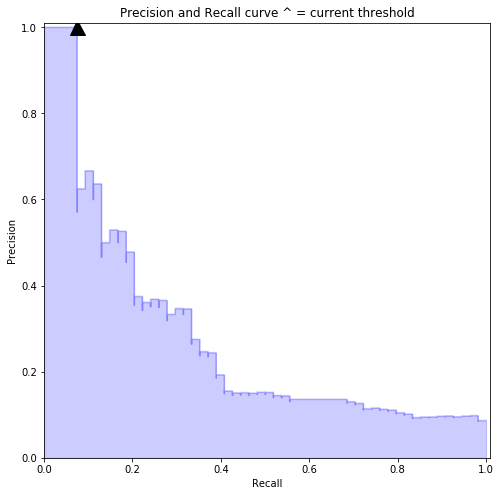

In [325]:
precision_recall_threshold(p, r, thresholds, predictions, yvalid, t=0.42)

As expected, our model is leaning heavily towards classifying true positives at the expense of true negatives. Let's tune the threshold until we have a minimal false negative rate.

     pred_neg  pred_pos
neg       138       490
pos         1        53


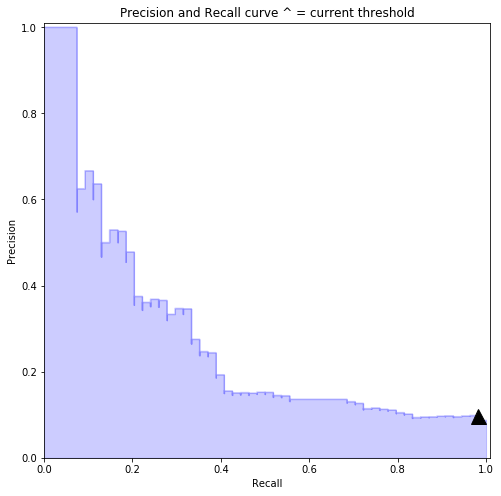

In [326]:
precision_recall_threshold(p, r, thresholds, predictions, yvalid, t=0.04)

A threshold probability of 0.04 seems to be the optimal value for this model and our application

In [327]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

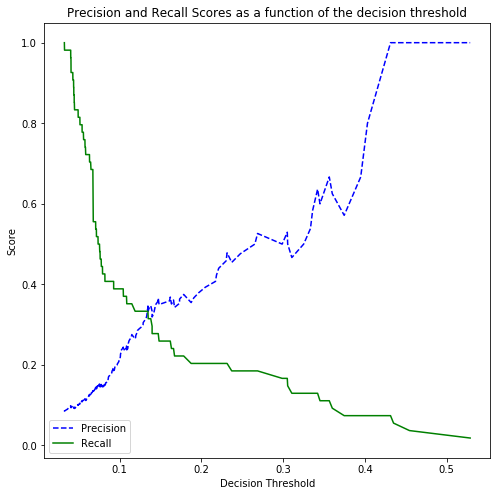

In [328]:
plot_precision_recall_vs_threshold(p, r, thresholds)

Performing the binary classification here using just word counts or tf-idf gives us some predictive power. However, if we want to use this to flag experiments that can't be safely processed automatically, we want a low false negative rate so that few to none get by. Unfortunately, our multispecies detector is flagging 10x more false positives than true positives, which would be a lot of manual work. This could still be helpful though if we are able to further classify the subset of flagged examples by stacking with another model and more information.

We initially stated that we had aspirations to extend the binary classification to a multi-class task. However, the binary classification performance doesn't bode well for our ability to further predict which species make up the multispecies class using our existing feature space. 

We can try acquiring more data from the full papers and a pretrained model on which to apply transfer learning. The need for more data is consistent with the high variance we see of our train performance being much lower than our validation set performance. Let's try a different feature extraction method, as maybe we're losing information in our existing data that we could preserve and thus improve our performance without collection additional data.

We should also check an interpretable model, such as logistic regression with l1 loss, to try understanding what words are providing the most predictive weight. This might provide actionable insight into how to improve our feature selection.

### Using GloVe embedding

In [154]:
# Download GloVe vectors dictionary
import urllib.request

url = 'http://www-nlp.stanford.edu/data/glove.840B.300d.zip'
urllib.request.urlretrieve(url, 'raw/glove.840B.300d.zip')

import zipfile
zip_ref = zipfile.ZipFile('raw/glove.840B.300d.zip', 'r')
zip_ref.extractall('raw')
zip_ref.close()

In [90]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('raw/glove.840B.300d.txt')
for i, line in enumerate(tqdm(f)):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:05, 17481.18it/s]

Found 2196016 word vectors.


In [93]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in xtrain]
xvalid_glove = [sent2vec(x) for x in xvalid]
xtest_glove = [sent2vec(x) for x in xtest]

In [97]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
xtest_glove = np.array(xtest_glove)

In [99]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

logloss: 0.271 


In [100]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

logloss: 0.351 


The model using the GloVe embedding seems to perform worse for XGBoost. Maybe this isn't surprising considering that the GloVe dictionary doesn't contain any domain-specific proteomics words. We could verify this by checking what proportion of words in our training set are not in the GloVe dictionary. Let's move on for now -- we'll certainly come back to embeddings when we start trying to run deep nets on the full papers.

## Test set evaluation

We left our best optimized model in the `model` variable. Let's test with that.

In [211]:
xtest_tfv = tfv.transform(xtest)
xtest_ctv = ctv.transform(xtest)

In [331]:
predictions = model.predict_proba(xtrain_tfv.tocsc())
print ("logloss train: %0.3f " % metrics.log_loss(ytrain, predictions))

predictions = model.predict_proba(xvalid_tfv.tocsc())
print ("logloss valid: %0.3f " % metrics.log_loss(yvalid, predictions))

logloss: 0.168 
logloss: 0.249 


logloss test: 0.246 
accuracy: 0.923 
698 0 58 2
recall: 0.050 
precision: 0.750 
     pred_neg  pred_pos
neg       697         1
pos        57         3


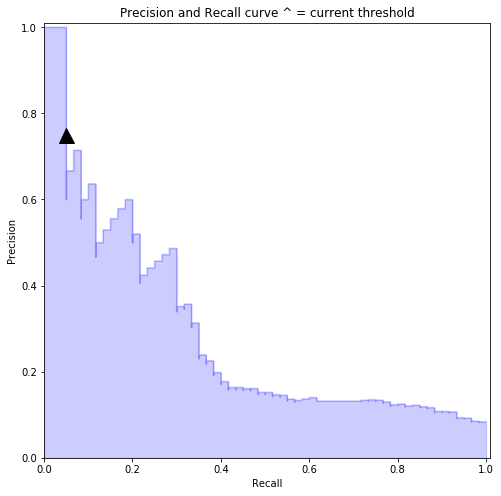

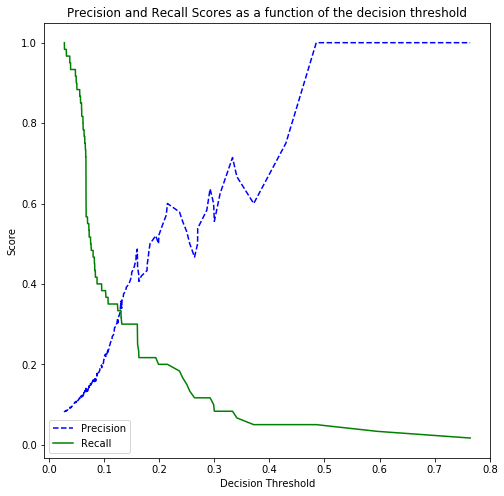

In [341]:
predictions = model.predict_proba(xtest_tfv.tocsc())[:, 1]
print ("logloss test: %0.3f " % metrics.log_loss(ytest, predictions))

bin_predictions = adjusted_classes(predictions, t=0.42)
print ("accuracy: %0.3f " % metrics.accuracy_score(ytest, pred_binary))
tn, fp, fn, tp = metrics.confusion_matrix(ytest, pred_binary).ravel()
print(tn, fp, fn, tp)


print("recall: %0.3f " % metrics.recall_score(ytest, bin_predictions))
print("precision: %0.3f " % metrics.precision_score(ytest, bin_predictions))
p, r, thresholds = metrics.precision_recall_curve(ytest, predictions)
precision_recall_threshold(p, r, thresholds, predictions, ytest, t=0.42)
plot_precision_recall_vs_threshold(p, r, thresholds)

### Summary

Before we go collecting a larger dataset, it would be good to perform another survey of the NLP literature for feature extraction methods to ensure that we've fully explored our current dataset.

Also, we still need to try some exploration with interpretable models. Writing a quick RNN classifier in keras would be worth attempting on this data before moving on.

# Next steps

- [ ] Turn reference data into URLs for each paper
- [ ] Download all papers
- [ ] Continue exploration of bibliometric techniques

I'd like to better understand how to approach the problem of building proteomics-specific knowledge into existing NLP models.

## Using the latest in NLP and bibliometrics

This article provides a review of the latest advances in NLP of academic papers: https://www.frontiersin.org/articles/10.3389/frma.2019.00002/full

Here's a possible method for handling out-of-vocabulary words by combining Word2Vec with a domain-specific dictionary: Intelligent Word Embeddings https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5771955/

